In [1]:
## Importing necessary dependencies & libraries 
import cv2 
import numpy as np
import pandas as pd
import os
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop

print("All Done!!")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

All Done!!


# Getting the code into a panda's DataFrame

In [2]:
# Put data into pandas dataframe: 

# Columns: file_name, object_id, mask_status, location_on_img
data = {
    'filename':[],# Picture object is in
    'file_num':[],
    'object_id':[],  # Unique ID formula = file_name number + '-' + Object number
    'mask_status':[],  # with_mask, without_mask, mask_worn_incorrectly
    'location_on_img':[]  # (xmin, ymin, xmax, ymax) --> square
}


directory_path = '/kaggle/input/face-mask-detection/annotations'
xml_files = os.listdir(directory_path)

def remove_char(string: str):
    done = ""
    for char in string: 
        if char=='1' or char=='2' or char=='3' or char=='4' or char=='5' or char=='6' or char=='7' or char=='8' or char=='9' or char=='0':
            done = done + char
    return done            

def read_xml_file(xml_file):
    tree = ET.parse(os.path.join(directory_path, xml_file))
    root = tree.getroot()
    file_name = root.find("filename").text
    
    objects = root.findall('object')  # List of objects
    for i, obj in enumerate(objects): 
        #print(str(len(objects)) + " - " + str(file_name) + "-" + str(i))
        data['filename'].append(file_name)
        data['object_id'].append(remove_char(file_name) + "-" + str(i)) 
        data['file_num'].append(remove_char(file_name))
        data['mask_status'].append(obj.find('name').text)
        data['location_on_img'].append((
            int(obj.find('bndbox/xmin').text),
            int(obj.find('bndbox/ymin').text),
            int(obj.find('bndbox/xmax').text),
            int(obj.find('bndbox/ymax').text)
        ))
                    
for file in xml_files: 
    #print(file)
    read_xml_file(file)
    
df = pd.DataFrame(data)
df['file_num'] = pd.to_numeric(df['file_num'])
df = df.sort_values('file_num')
del df['file_num']

# Uncomment to display DataFrame
df.head(100)

    

,filename,object_id,mask_status,location_on_img
978,maksssksksss0.png,0-0,without_mask,"(79, 105, 109, 142)"
979,maksssksksss0.png,0-1,with_mask,"(185, 100, 226, 144)"
980,maksssksksss0.png,0-2,without_mask,"(325, 90, 360, 141)"
3460,maksssksksss1.png,1-5,with_mask,"(191, 67, 221, 93)"
3461,maksssksksss1.png,1-6,with_mask,"(21, 73, 44, 93)"
...,...,...,...,...
3342,maksssksksss24.png,24-0,mask_weared_incorrect,"(105, 76, 161, 116)"
2972,maksssksksss25.png,25-0,with_mask,"(122, 68, 195, 152)"
1530,maksssksksss26.png,26-0,with_mask,"(73, 87, 174, 206)"
1531,maksssksksss26.png,26-1,with_mask,"(245, 152, 327, 239)"


## Visualize some faces & respective "mask_status" 

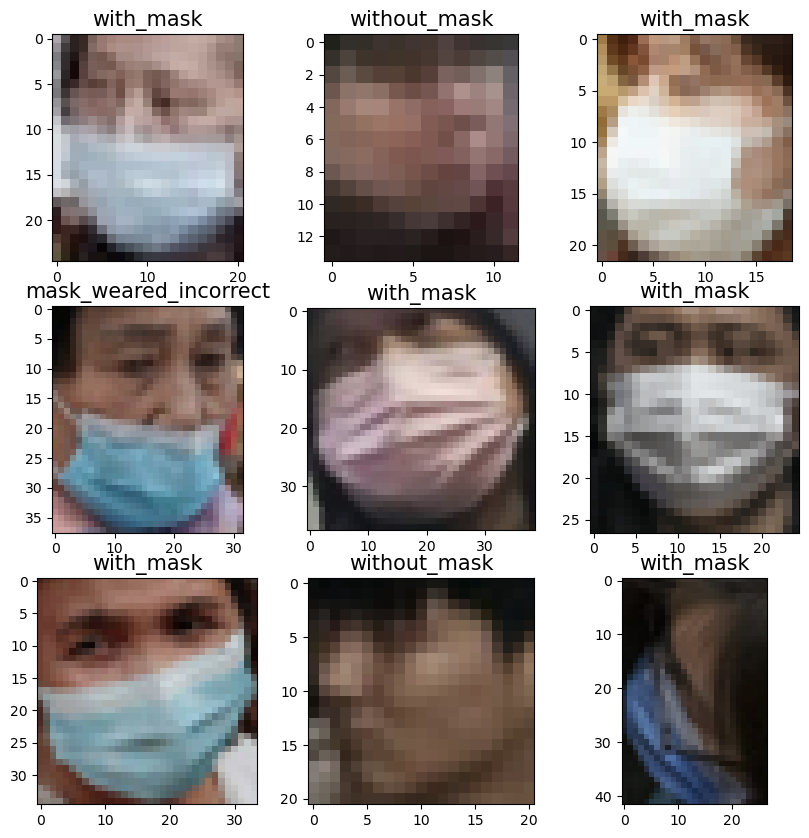

In [3]:
import matplotlib.pyplot as plt
import random

img_dir_path = "/kaggle/input/face-mask-detection/images"

plt.figure(figsize=(10,10))
for i in range(0,9):
    random_num = random.randint(0,len(df))
    plt.subplot(3,3,i+1)
    img = cv2.imread(img_dir_path + "/" + str(df.loc[random_num, "filename"]))
    
    #x1, y1, x2, y2 == coord[0][1][2][3]
    coord = tuple(df.loc[random_num, 'location_on_img'])
    face = img[coord[1]:coord[3], coord[0]:coord[2]]
    plt.imshow(cv2.cvtColor(face, cv2.COLOR_RGB2BGR))
    plt.title(df.loc[random_num, 'mask_status'], size = 15)

plt.show()
    

## Splitting the Data into Testing and Training
 Remember to insert the actual images into the train_test_split --> This takes some time to run

In [4]:
from sklearn.model_selection import train_test_split

# Read and preprocess the images
image_data = []
img_dir_path = '/kaggle/input/face-mask-detection/images'
for i, file_name in enumerate(df['filename']):
    image = cv2.imread(img_dir_path + "/" + str(file_name), cv2.IMREAD_GRAYSCALE)  # Read the image using OpenCV
    
    # Perform any necessary preprocessing steps, such as resizing or normalizing the image
    preprocessed_image = cv2.resize(image, (150,150))
    if df['mask_status'][i] == "with_mask":
        image_data.append([preprocessed_image, 1]) # 1 Appended if subject has mask
#     else: 
        image_data.append([preprocessed_image, 0]) # 0 Appended if subject does not have mask/worn incorrectly

# Convert the list of preprocessed images into a numpy array
dataset = np.array(image_data)

# Print the shape of X to verify
print(dataset.shape)

# labels = df['mask_status']  
# x_train, x_test, y_train, y_test = train_test_split(pictures, labels, test_size=0.2, random_state=50)  # 80% Train, 20% Test


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


(6464, 2)


/tmp/ipykernel_20/4162110932.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset = np.array(image_data)


In [5]:

print(dataset[:10])

[[array([[99, 88, 71, ..., 26, 25, 78],
         [86, 81, 67, ..., 28, 21, 63],
         [82, 79, 65, ..., 27, 31, 67],
         ...,
         [85, 87, 84, ..., 28, 28, 28],
         [83, 86, 82, ..., 28, 28, 28],
         [91, 97, 97, ..., 34, 29, 28]], dtype=uint8) 1]
 [array([[99, 88, 71, ..., 26, 25, 78],
         [86, 81, 67, ..., 28, 21, 63],
         [82, 79, 65, ..., 27, 31, 67],
         ...,
         [85, 87, 84, ..., 28, 28, 28],
         [83, 86, 82, ..., 28, 28, 28],
         [91, 97, 97, ..., 34, 29, 28]], dtype=uint8) 0]
 [array([[99, 88, 71, ..., 26, 25, 78],
         [86, 81, 67, ..., 28, 21, 63],
         [82, 79, 65, ..., 27, 31, 67],
         ...,
         [85, 87, 84, ..., 28, 28, 28],
         [83, 86, 82, ..., 28, 28, 28],
         [91, 97, 97, ..., 34, 29, 28]], dtype=uint8) 1]
 [array([[99, 88, 71, ..., 26, 25, 78],
         [86, 81, 67, ..., 28, 21, 63],
         [82, 79, 65, ..., 27, 31, 67],
         ...,
         [85, 87, 84, ..., 28, 28, 28],
         [83,

## Building the CNN Model Architecture 

In [6]:
image_height = 150
image_width = 150
num_channels = 3
num_classes = 3

# Define the CNN model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, num_channels)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 64)                5